In [1]:
import os, sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import integrate
from omfit_classes import omfit_eqdsk
from omfit_classes import utils_fusion
import matplotlib
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator
%matplotlib inline

In [67]:
#constant parameters
clight = 3e8 #m/s
gfile = omfit_eqdsk.OMFITgeqdsk('gNARC_k14d05R455a120')#'gNTARC_iter1_small_pedestal_n_17')

R_0 = gfile['RCENTR']
psin = gfile['fluxSurfaces']['geo']['psin']
#print(gfile['fluxSurfaces']['geo'].keys())

print(gfile['AuxQuantities'].keys())

['R', 'Z', 'PSI', 'PSI_NORM', 'PSIRZ', 'PSIRZ_NORM', 'RHOp', 'RHOpRZ', 'FPOLRZ', 'PRESRZ', 'QPSIRZ', 'FFPRIMRZ', 'PPRIMERZ', 'PRES0RZ', 'Br', 'Bz', 'Bp', 'Bt', 'Jr', 'Jz', 'Jt', 'Jp', 'Jt_fb', 'Jpar', 'PHI', 'PHI_NORM', 'PHIRZ', 'RHOm', 'RHO', 'RHORZ', 'Rx1', 'Zx1', 'Rx2', 'Zx2']


In [57]:
#constant parameters
clight = 3e8 #m/s

# class in which the tokamamk information is stored
class tokamak():
    #this class contains information on the equilibrium geometry and the
    #tokamak profiles. tokamak profiles can be assigned with either a file
    #containing the profile data (not yet implemented) or parabolic profiles
    
    def __init__(self):
        #name and eqdskfile
        self.machinename='manta'
        self.eqdsk_name ='gNTARC_iter1_small_pedestal_n_17'#'gNTARC_iter1_Stuart'#'GARC_4.55R_1.2a_updatedProfiles_altgeqdsk'

        #profiles
        self.prof_type = 'parab'

        # temperature [keV]
        self.Te_0 = 24.97
        self.Te_sep = 0.553
        self.Te_alpha1 = 1.4848
        self.Te_alpha2 = 1.1313

        self.Ti_0 = 24.97
        self.Ti_sep = 0.553
        self.Ti_alpha1 = 1.4848
        self.Ti_alpha2 = 1.1313

        #density [10^20 m^-3]
        self.n_0 = 2.87
        self.n_sep = 0.95
        self.n_alpha1 = 2.1212
        self.n_alpha2 = 1.6154

        self.Mi = 2.5

    #initializes geometry and flux grid
    def get_eqdsk_info(self):
        gfile = omfit_eqdsk.OMFITgeqdsk(self.eqdsk_name)
        self.gfile = gfile
        #get sq_psi_n grid (maybe add other grid options in future?)
        psin = gfile['fluxSurfaces']['geo']['psin']
        #gfile.plot()
        sqpsin = np.sqrt(psin)
        self.rho = sqpsin
        self.N_rho = len(sqpsin)
        self.fluxSurfaceAvgr = gfile['fluxSurfaces']['geo']['rho']#['fluxSurfaces']['geo']['a']
        self.fluxSurfaceAvgr[0] = np.min(gfile['fluxSurfaces']['geo']['a'])

        #get a (at the midplane) and R_0
        rminn = gfile['fluxSurfaces']['geo']['a']
        self.a = rminn[-1]
        self.R_0 = gfile['RCENTR']

        #areas and volumes
        self.area_surf = gfile['fluxSurfaces']['geo']['surfArea']
        self.area_cross = gfile['fluxSurfaces']['geo']['cxArea']
        self.vol = gfile['fluxSurfaces']['geo']['vol']
        
        #B-field
        self.B_0 = gfile['BCENTR']

        #current
        self.I_p = gfile['CURRENT']/1.0e6
        self.J_tavg = (gfile['fluxSurfaces']['avg']['Jt'])
        
        self.q_prof = gfile['QPSI']  #safety factor profile (N_rho long)
        self.pressure_prof = gfile['PRES'] #pressure profile

        self.rlim = gfile["RLIM"] #R points of the wall
        self.zlim = gfile["ZLIM"] #Z points of the wall
        self.rbbbs = gfile["RBBBS"] #R points of the LCFS
        self.zbbbs = gfile["ZBBBS"] # Z points of the LCFS       
                

        

    #helper routine for init_profs
    def __f_parab(self,A_0,A_s,a_1,a_2,x):
        return (A_0 - A_s)*(1-x**a_1)**a_2 + A_s
    
    #lets user use trinity profiles
    def set_trinity_Te_prof(self, trinity_Te_profile):
        self.trinity_Te_profile = trinity_Te_profile

    #intializes T,n,eta profiles
    def init_profs(self, filename=''):
        gfile = omfit_eqdsk.OMFITgeqdsk(self.eqdsk_name)
        if self.prof_type == 'parab':
            self.Te_prof = self.__f_parab(self.Te_0,self.Te_sep,self.Te_alpha1,\
                                     self.Te_alpha2,self.rho)
            self.Ti_prof = self.__f_parab(self.Ti_0,self.Ti_sep,self.Ti_alpha1,\
                                     self.Ti_alpha2,self.rho)
            self.n_prof = self.__f_parab(self.n_0,self.n_sep,self.n_alpha1,self.\
                                    n_alpha2,self.rho)

            self.Zeff_prof = 2 + np.zeros(len(self.Te_prof))

            #neoclassical conductivity profile
            self.neoclass_conductivity_prof = utils_fusion.nclass_conductivity_from_gfile(gEQDSK = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff', Zis = [2])[0]
            #flux averaged bootstrap current profile
            self.J_BS_prof = utils_fusion.sauter_bootstrap(gEQDSKs = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, 
                                                        Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),
                                                        charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff',
                                                        Zis = [2], R0 = self.R_0, p = np.array([self.pressure_prof]), version = 'osborne')[0]
            #there are some divide by zeros in the above calculation, so this smooths that over. Bandaid fix.
            self.J_BS_prof[np.isnan(self.J_BS_prof)] = 0; self.J_BS_prof[self.J_BS_prof == np.inf] = 0

            #neoclassical resistivity profile
            self.neoEta_prof = utils_fusion.eta_par_neo(zeff = self.Zeff_prof, te = self.Te_prof*1e3, 
                ne = self.n_prof*1e20, q = self.q_prof, R0 = (self.R_0 + np.zeros(len(self.Te_prof))), rho = self.fluxSurfaceAvgr)


            """
            fig,ax = plt.subplots()
            ax.plot(self.rho, self.J_BS_prof, label = 'BS')
            ax.plot(self.rho, self.J_tavg, label = 'flux avg J')
            ax.legend()
            plt.show()
            """

            """
            fig,ax = plt.subplots()
            ax.plot(self.rho, self.Te_prof*1e3, label = "Te prof",color ='r')
            ax1= ax.twinx()
            ax1.plot(self.rho, self.n_prof*1e20, label = "ne prof", color = 'b')
            ax.legend()
            ax1.legend()
            plt.show()
            """
        
        elif self.prof_type == 'trinity':
            print('TRINITY CALLED')
            self.Te_prof = self.trinity_Te_profile  # set the Te profile from trinity 
            self.Ti_prof = self.__f_parab(self.Ti_0,self.Ti_sep,self.Ti_alpha1,\
                                     self.Ti_alpha2,self.rho)
            self.n_prof = self.__f_parab(self.n_0,self.n_sep,self.n_alpha1,self.\
                                    n_alpha2,self.rho)

            self.Zeff_prof = 2 + np.zeros(len(self.Te_prof))

            #neoclassical conductivity profile
            self.neoclass_conductivity_prof = utils_fusion.nclass_conductivity_from_gfile(gEQDSK = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff', Zis = [2])[0]
            #flux averaged bootstrap current profile
            self.J_BS_prof = utils_fusion.sauter_bootstrap(gEQDSKs = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, 
                                                        Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),
                                                        charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff',
                                                        Zis = [2], R0 = self.R_0, p = np.array([self.pressure_prof]), version = 'osborne')[0]
            #there are some divide by zeros in the above calculation, so this smooths that over. Bandaid fix.
            self.J_BS_prof[np.isnan(self.J_BS_prof)] = 0; self.J_BS_prof[self.J_BS_prof == np.inf] = 0

            #neoclassical resistivity profile
            self.neoEta_prof = utils_fusion.eta_par_neo(zeff = self.Zeff_prof, te = self.Te_prof*1e3, 
                ne = self.n_prof*1e20, q = self.q_prof, R0 = (self.R_0 + np.zeros(len(self.Te_prof))), rho = self.fluxSurfaceAvgr)
        else:
            raise Exception('no other prof_types supported rn')
        
    def get_Te_from_J(self, J_rho):
        R0 = self.R_0
        rho = self.rho
        a = self.a
        if len(J_rho) != len(rho):
            raise ValueError(f'Array length error. Length of J_rho = {len(J_rho)},\
                             length of rho = {len(rho)}')
        r_array = rho*a
        neoEta = self.neoEta_prof  
        # Find integration constant to conserve the Ip total current. Note chease redoes this so
        # this is not actually critical for the output profile. 
        C = self.gfile['CURRENT']/integrate.cumtrapz((1/(neoEta*R_0)), self.area_cross)[-1]
        
        R = R = self.gfile['fluxSurfaces']['geo']['R'] 
        
        return ((3.3e-8)*(R/C)*(1 - (r_array/R0)**0.5)**(-2)*J_rho)**(2/3)
        
        
        
        
        

In [58]:
jakomak = tokamak()
jakomak.eqdsk_name = 'gNTARC_paper' #'gNTARC3'
jakomak.get_eqdsk_info()
jakomak.init_profs()

  sauter_bootstrap: extracting data from gfiles...


Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.
Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


In [27]:
jakomak.I_p

9.99951741

In [28]:
manta = tokamak()
manta.get_eqdsk_info()
manta.init_profs()

  sauter_bootstrap: extracting data from gfiles...


Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.
Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


In [8]:
# calculate bootstrap fraction 
f_bs = integrate.cumtrapz(manta.J_BS_prof, manta.area_cross)[-1]/integrate.cumtrapz(manta.J_tavg,manta.area_cross)[-1]
print(f"f_bs: {f_bs}")

f_bs: 0.2943474674259184


Text(0, 0.5, '$J_{BS}$($\\rho$) [A/m$^2$]')

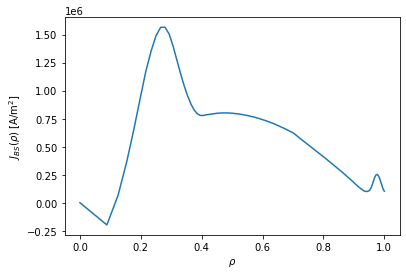

In [9]:
%matplotlib inline
plt.plot(manta.rho, manta.J_BS_prof)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$J_{BS}$($\rho$) [A/m$^2$]')

Text(0.5, 1.0, 'Built-in $T_e$ profile')

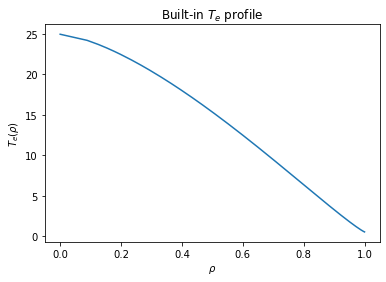

In [10]:
plt.plot(manta.rho, manta.Te_prof)
plt.ylabel(r'$T_e(\rho)$')
plt.xlabel(r'$\rho$')
plt.title(r'Built-in $T_e$ profile')

Text(0.5, 0, '$\\rho$')

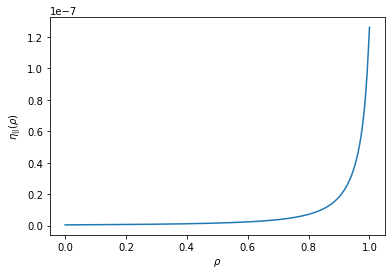

In [11]:
plt.plot(manta.rho, manta.neoEta_prof)
plt.ylabel(r'$\eta_{||}(\rho)$')
plt.xlabel(r'$\rho$')

1.0
1.0
dict_keys(['trinity_infile', 'species', 'species_tags', 'n_evolve_species', 'T_evolve_species', 'time', 'grid', 'geo', 'norms', 't', 'n_D', 'p_D', 'T_D', 'pflux_D', 'qflux_D', 'heat_D', 'aLn_D', 'aLT_D', 'aLp_D', 'Sn_aux_D', 'Sp_aux_D', 'Sp_alpha_D', 'Sp_rad_D', 'Sp_heating_D', 'Sp_coll_D', 'Sp_tot_D', 'Sp_aux_int_MW_D', 'Q_MW_D', 'Sp_tot_int_MW_D', 'Gam_SI20_D', 'Sn_tot_int_SI20_D', 'n_e', 'p_e', 'T_e', 'pflux_e', 'qflux_e', 'heat_e', 'aLn_e', 'aLT_e', 'aLp_e', 'Sn_aux_e', 'Sp_aux_e', 'Sp_alpha_e', 'Sp_rad_e', 'Sp_heating_e', 'Sp_coll_e', 'Sp_tot_e', 'Sp_aux_int_MW_e', 'Q_MW_e', 'Sp_tot_int_MW_e', 'Gam_SI20_e', 'Sn_tot_int_SI20_e', 'Palpha_MWm3', 'Palpha_int_MW', 'solver_jacobian', 'solver_rhs'])
---
{'N_radial': 9, 'rho_edge': 0.9, 'rho_inner': 0.052941176470588235, 'rho_axis': array([0.05294118, 0.15882353, 0.26470588, 0.37058824, 0.47647059,
       0.58235294, 0.68823529, 0.79411765, 0.9       ]), 'mid_axis': array([0.10588235, 0.21176471, 0.31764706, 0.42352941, 0.52941176

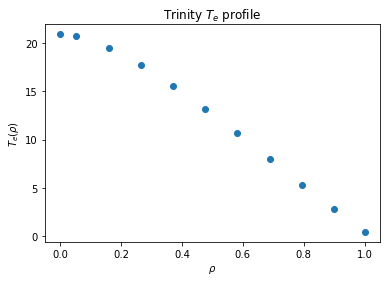

In [68]:
def convert(rho1,rho2,prof1):
    prof1fun = PchipInterpolator(rho1,prof1)
    rhoconvfun = PchipInterpolator(rho2,rho1)
    prof2 = prof1fun(rhoconvfun(rho2))
    prof2fun = PchipInterpolator(rho2,prof2)
    assert np.all(prof1fun(rho1)-prof2fun(rho2) == 0)
    return prof2fun

rho_pol = np.sqrt(gfile['AuxQuantities']['PSI_NORM'])
rho_tor = np.sqrt(gfile['AuxQuantities']['PHI_NORM'])
print(rho_pol[-1])
print(rho_tor[-1])
#with open('log_trinity.npy', 'rb') as f:#'NTARC_zeta_iter1b_ray_EQDSK.npy', 'rb') as f:
#log_trinity_n180.npy
with open('log_trinity_Ip88.npy', 'rb') as f:  #'transport_iter1b_new.npy' 'log_trinity_hires.npy' 'log_trinity_Ip88.npy'
    data = np.load(f, allow_pickle=True).tolist()
#data = np.load('NTARC_zeta_iter1b_ray_EQDSK.npy', allow_pickle=True).tolist()
print(data.keys())
time = np.array( data['time'  ] )
#tags = data['species_tags']
#print(data['p_e'][-1].shape[0])
print('---')
print(data['grid'])
T_e = data['p_e'][-1]/data['n_e'][-1] #data['T_e'][-1]
trinity_rho = data['grid']['rho_axis']
print('-----*-')
print(trinity_rho)
trinity_rho = np.append(np.array([0]), trinity_rho)
trinity_rho = np.append(trinity_rho, np.array([1]))
#trinity_rho = np.array([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
#trinity_rho = np.linspace(0, 1, 5)
T_e = np.append(np.array([T_e[0]*1.01]), T_e)
T_e = np.append(T_e, np.array([0.435]))
plt.scatter(trinity_rho, T_e)
#plt.plot(manta.rho, manta.Te_prof)
plt.ylabel(r'$T_e(\rho)$')
plt.xlabel(r'$\rho$')
plt.title(r'Trinity $T_e$ profile')
print(trinity_rho)

# T_i
T_i = data['p_D'][-1]/data['n_D'][-1] #data['T_e'][-1]
T_i = np.append(np.array([T_i[0]*1.01]), T_i)
T_i = np.append(T_i, np.array([0.435]))

# new stuff for pressure profile matching 
pcore = data['p_e'][-1] + data['p_D'][-1]  # right now, D includes T 
pcore = np.append(np.array(pcore[0]*1.01), pcore)
pcore = np.append(pcore, np.array([0]))
pcore = pcore*1e3*1.6e-19*1e20


#------------------------------------------------------------
# NEW SECTION: carfully change trinity_rho, which is rho_tor, to rho_pol, 
# as is used in the rest of the script

rhocore = trinity_rho#np.array([0.1, 0.3, 0.5, 0.7, 0.9])
rhopcore = np.array([0.2,0.4,0.6,0.8])
psicore = rhocore**2
psipcore = np.array([(psicore[i+1]+psicore[i])/2 for i in range(len(psicore)-1)])
#ppcore_trinity = -1/2/rhopcore*1.6e4*(data['aLpe'][-1]/a*np.interp(psipcore,psicore,data['pe'][-1])+data['aLpi'][-1]/a*np.interp(psipcore,psicore,transport['pi'][-1]))
# ncore = data['n'][-1]
# Tecore = data['pe'][-1]/ncore
# Ticore = data['pi'][-1]/ncore

<IPython.core.display.Javascript object>


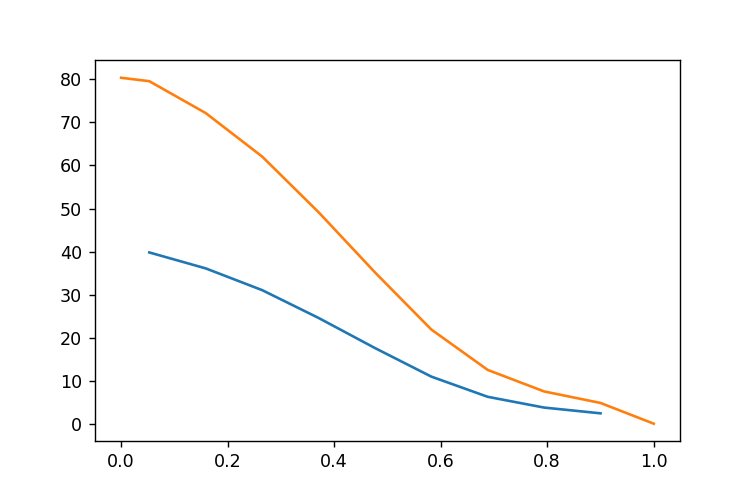

In [30]:
jjj = 1e3*1.6e-19*1e20
plt.plot(data['grid']['rho_axis'], data['p_e'][-1])
plt.plot(trinity_rho, pcore/jjj)

Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.
Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


  sauter_bootstrap: extracting data from gfiles...
TRINITY CALLED
  sauter_bootstrap: extracting data from gfiles...


Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.
Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


<IPython.core.display.Javascript object>


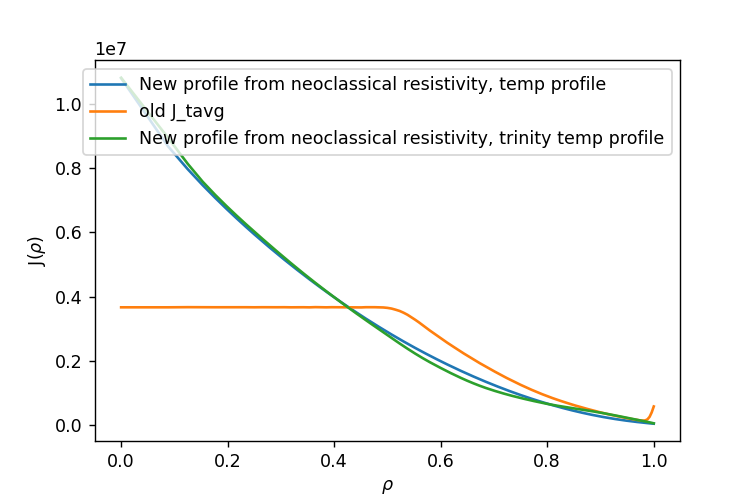

Ip =  8788773.40576114
Ip2 =  9999063.55
Ip3 =  8699963.419999998
trinity
[10814827.36654741  8939838.85807518  8135133.4109658   7577272.70988517
  7163442.04539707  6820930.43328753  6524450.62681415  6260408.45035564
  6020372.68438195  5798782.4569216   5591857.25823185  5397450.10499381
  5214099.46397088  5040632.83869347  4876085.12218151  4719652.57691596
  4570655.57878825  4428508.89335222  4292652.72409221  4162178.45680789
  4036540.47505394  3915350.39070874  3798271.78273963  3685009.79859613
  3575304.08120733  3468923.63449582  3365662.68824977  3265333.47293179
  3167765.37217798  3072806.28830332  2979610.81983209  2887486.90727713
  2796786.47154637  2707815.29889849  2620833.23121276  2536061.85391018
  2453689.39782118  2373875.4710579   2296744.97374242  2222387.76558587
  2150869.87656526  2082238.84201216  2016525.09468883  1953744.91446778
  1893622.41448303  1834991.41798412  1777793.83322124  1722099.20714641
  1667966.0556294   1615443.00259941  1564570.9694

In [31]:
# New area for creating a current profile from a temp and rho profile 
from scipy import interpolate
def get_Jtor_from_T(rho_array, T_array, a0, R0):
    """
    rho_array: flux surface coordinate #TODO: make sure this is being treated properly 
    T_array: total temperature in KeV
    a: device minor radius
    R: device major radius 
    """
    r = rho_array*a0 # get minor radius array
    R = R0 + r # only postive values of r?
    eta_tor_CL = 3.3e-8*(1/T_array)**(3/2) # Eq. 11.15 in Plasma Physics and Fusion Energy 
    eta_tor_NCL = eta_tor_CL/(1 - (r/R0)**0.5)**2  # Eq 15.7 in Plasma Physics and Fusion Energy
    return 1/(R*eta_tor_NCL)
# New area for creating a current profile from a temp and rho profile 

# USE THIS ONE
def get_Jtor_from_T2(tokamak, trinity_Te, trinity_rho, trinity_Ti):
    """
    tokamak: tokamak object from Sam's loop voltage code 
    return: C/neoEta, where C is integration constant to give flux surface averaged integral of Ip
    """
    rho = tokamak.rho
    #temp_prof_func = interpolate.interp1d(trinity_rho, trinity_Te, 'cubic') # create a new temp profile that has the 
                                                              # correct number of indicies to match 
                                                              # tokamak.rho
    temp_prof_func = interpolate.PchipInterpolator(trinity_rho, trinity_Te) # create a new temp profile that has the 
                                                          # correct number of indicies to match 
                                                          # tokamak.rho
    temp_prof_interped =  temp_prof_func(rho)        # call said interpolated function 
    
    timp_prof_func = interpolate.PchipInterpolator(trinity_rho, trinity_Ti) # create a new temp profile that has the 
                                                          # correct number of indicies to match 
                                                          # tokamak.rho
    timp_prof_interped =  timp_prof_func(rho)        # call said interpolated function 
    tokamak.set_trinity_Te_prof(temp_prof_interped)  # use class method to load up this profile 
    tokamak.prof_type='trinity'                      # update profile type. For now, only overwrites 
    tokamak.init_profs()                             #   the Te profile 
    R = tokamak.gfile['fluxSurfaces']['geo']['R']    # not used rn. E goes as 1/R, but need flux surface variables
    neoEta = tokamak.neoEta_prof  
    # Find integration constant to conserve the Ip total current. Note chease redoes this so
    # this is not actually critical for the output profile. 
    C = tokamak.gfile['CURRENT']/integrate.cumtrapz((1/(neoEta*tokamak.R_0)), tokamak.area_cross)[-1]
    return C/(tokamak.R_0*neoEta), temp_prof_interped, timp_prof_interped

def get_Jtor_from_T3(tokamak):
    """
    tokamak: tokamak object from Sam's loop voltage code 
    """
    rho = tokamak.rho
    R = tokamak.gfile['fluxSurfaces']['geo']['R']
    neoEta = tokamak.neoEta_prof #TODO: should replace this with using the trinity temp profile 
    C = tokamak.gfile['CURRENT']/integrate.cumtrapz((1/(neoEta*tokamak.R_0)), tokamak.area_cross)[-1]
    return C/(tokamak.R_0*neoEta)
manta = tokamak()
manta.eqdsk_name = 'gMANTA_iter2_Ip88_k14' #'gMANTA_Ip8-7_k1-40' #'gMANTA_iter2_Ip88_k14'#'gNARC_k14d05R455a120' #'gNTARC_paper' #'gNTARC3'
manta.get_eqdsk_info()
manta.init_profs()
Jnew = get_Jtor_from_T3(manta)
Jnew_trinity, Tnew_trinity, Tinew_trinity = get_Jtor_from_T2(manta, T_e, trinity_rho, T_i)
#Jnew = Jnew*(max(manta.J_tavg)/max(Jnew))
#print(manta.gfile['fluxSurfaces']['geo']['R'])
#print('--')
#print(manta.rho)

plt.plot(manta.rho, Jnew, label='New profile from neoclassical resistivity, temp profile')
plt.plot(manta.rho, manta.J_tavg, label='old J_tavg')
plt.plot(manta.rho, Jnew_trinity, label='New profile from neoclassical resistivity, trinity temp profile')
plt.legend()
plt.ylabel(r'J($\rho$)')
plt.xlabel(r'$\rho$')
Ip = integrate.cumtrapz(manta.J_tavg, manta.area_cross)[-1]
Ip3 = integrate.cumtrapz(Jnew, manta.area_cross)[-1]
Ip2 = gfile['CURRENT']
print('Ip = ', Ip)
print('Ip2 = ', Ip2)
print('Ip3 = ', Ip3)
print(manta.prof_type)
print(Jnew_trinity)
print(manta.eqdsk_name)
np.save('J_new_trinity.npy', Jnew_trinity)

In [27]:
# %matplotlib notebook
# T_test = manta.get_Te_from_J(manta.J_tavg)
# plt.plot(manta.rho, T_test)

In [32]:
# pressure profile fitting area
import numpy as np
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d


def sech(x):
    return 1/np.cosh(x)

def tanh_matcher(x, y2, x2, y1, x1, alpha, amin, amax, diagnostic_flag):
    """
    x: x-axis variable. Must be >= x2
    x1: x-value of first point to match to
    x2: x-value of second point to match to (x2 must be > x1)
    y1: y-value of first point to match to
    y2: y-value of second point to match to
    alpha: location of tanh curvature switch relative to x2 (must be posotive)
    amin: guess for minimum slope
    amax: guess for maximum slope
    diagnostic_flag: True will show plots for finding solution, False will hide plots
    """
    if x[-1] < x2:
        print('Error: using x value below tanh fitted function range')
    elif x2 < x1:
        print('Error: x2 must be greater than x1')
    elif y2 > y1:
        print('Error: this function only works for negative slope')
    
    slope = (y2 - y1)/(x2-x1)
    value = y2
    print(slope)
    alpha2 = alpha-x2 # shift to center on x2 instead of zero
    print('alpha2', alpha2)
    a_array = np.linspace(amin, amax, int(1e6))
    d1 = value/(1-np.tanh(a_array*x2 - alpha2))
    d2 = -slope/(a_array*sech(alpha2 - a_array*x2)**2)
    # Solve for intersection
    imin = np.where(np.abs(d2 - d1) == min(np.abs(d2 - d1)))
    if diagnostic_flag:
        ax3.plot(a_array, d1)
        ax3.plot(a_array, d2, 'r--')
        ax3.scatter(a_array[imin], d2[imin], marker='*', color='red')
    
    d = d2[imin]
    a = a_array[imin]
    
    return -d*np.tanh(a*x - alpha2) + d
 
def tanh_matcher_2_0(x, y2, x2, y1, x1, R, n, d, b, hmin, hmax, diagnostic_flag):

    """

    x: x-axis variable. Must be >= x2

    x1: x-value of first point to match to

    x2: x-value of second point to match to (x2 must be > x1)

    y1: y-value of first point to match to

    y2: y-value of second point to match to

    alpha: location of tanh curvature switch relative to x2 (must be posotive)

    amin: guess for minimum slope

    amax: guess for maximum slope

    diagnostic_flag: True will show plots for finding solution, False will hide plots

    """

    if x[-1] < x2:

        print('Error: using x value below tanh fitted function range')

    elif x2 < x1:

        print('Error: x2 must be greater than x1')

    elif y2 > y1:

        print('Error: this function only works for negative slope')

    S = (y2 - y1)/(x2-x1)

    P = y2

    print(S)

    R2 = R+x2 # shift to center on x2 instead of zero

    print('R2', R2)

    h_array = np.linspace(hmin, hmax, int(1e6))

    m1 = ((P - b) - (h_array/2)*(np.tanh((R2 - x2)/d)+1))/(R2 - x2 -d)**n

    m2 = -(S + h_array/(2*d)*(sech((R2-x2)/d))**2) / (n*(R2- x2 - d)**(n-1))

    # Solve for intersection

    imin = np.where(np.abs(m2 - m1) == min(np.abs(m2 - m1)))

    if diagnostic_flag:

        plt.plot(h_array, m1)

        plt.plot(h_array, m2, 'r--')

        plt.scatter(h_array[imin], m2[imin], marker='*', color='red')
        
    m = m2[imin]

    h = h_array[imin]
    
    return b + (h/2)*(np.tanh((R2-x)/d) + 1) + m* np.abs(R2 - x -d )**n * np.heaviside(R2-x-d, 0)
   





---
129
psicore.shape(): (11,)
pcore.shape(): (11,)
-1025957.1873696727
R2 0.9859705453537526


<IPython.core.display.Javascript object>


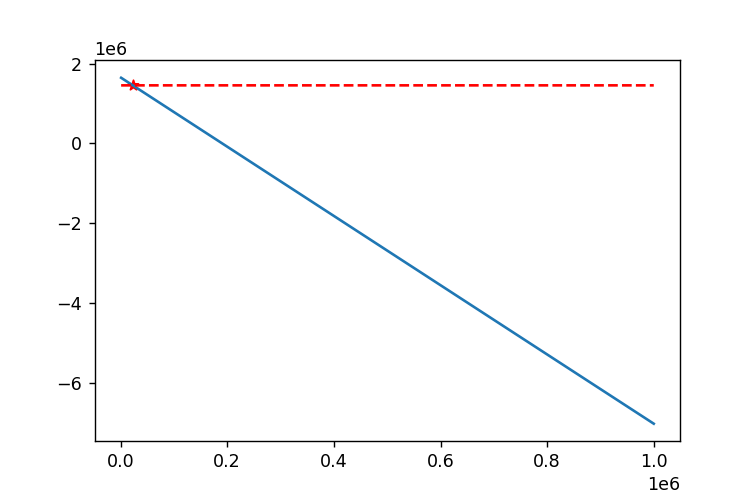

[0.         0.08838835 0.125      0.15309311 0.1767767  0.19764235
 0.21650635 0.23385359 0.25       0.26516504 0.2795085  0.29315098
 0.30618622 0.31868872 0.33071891 0.3423266  0.35355339 0.36443449
 0.375      0.38527588 0.39528471 0.40504629 0.4145781  0.42389562
 0.4330127  0.44194174 0.45069391 0.45927933 0.46770717 0.47598582
 0.48412292 0.49212549 0.5        0.5077524  0.5153882  0.52291252
 0.53033009 0.53764533 0.54486237 0.55198505 0.55901699 0.56596157
 0.57282196 0.57960116 0.58630197 0.59292706 0.59947894 0.60595998
 0.61237244 0.61871843 0.625      0.63121906 0.63737744 0.64347688
 0.64951905 0.65550553 0.66143783 0.66731739 0.6731456  0.67892378
 0.6846532  0.69033506 0.69597055 0.70156076 0.70710678 0.71260964
 0.71807033 0.72348981 0.72886899 0.73420876 0.73950997 0.74477346
 0.75       0.75519037 0.76034532 0.76546554 0.77055175 0.7756046
 0.78062475 0.78561282 0.79056942 0.79549513 0.80039053 0.80525617
 0.81009259 0.8149003  0.81967982 0.82443162 0.8291562  0.83385

NameError: name 'ax1' is not defined

In [33]:
a = 1.2 #[m]

#core stuff

# ppcore = np.array([(pcore[i+1]-pcore[i])/(psicore[i+1]-psicore[i]) for i in range(len(pcore)-1)]) #dp/d(psinorm)
# psipcore = np.insert(psipcore,0,0)
# ppcore = np.insert(ppcore,0,0)
# ppcore_trinity = np.insert(ppcore_trinity,0,0)
# psicore = np.insert(psicore,[0,2,len(psicore)],[0,0.16,1])
# pcore = np.insert(pcore,[0,2,len(pcore)],[pcore[0]+1e3,(pcore[1]+pcore[2])*0.495,0])

# #ppcore = ppcore_trinity





# #fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[12, 6.5])
# # Plot input pressure gradient
# Pprime_in = manta.gfile['PPRIME'].copy()
# #Pprime_in /= Pprime_in[0]
# psi_norm = np.linspace(0,1,len(Pprime_in))#np.concatenate([np.linspace(0,0.01,10),np.linspace(0.01,0.09,100),np.linspace(0.09,1,300)])#len(Pprime_in))
# #ax1.plot(psi_norm,Pprime_in)
# #psi_norm = psi_norm[20:np.argmin(np.abs(psi_norm-0.9**2))]
# Pprime_new = np.zeros(len(psi_norm))
# psia = psicore[0]
# psib = psicore[1]
# ppa = 0
# k = 1
# n = 0
# pa = pcore[0]
# pb = pcore[1]
# psin = psi_norm[n]
# while n<len(psi_norm):
#     print("entering")
#     c = (pb - pa - ppa*(psib - psia))/(0.5*(psib**2 - psia**2) - psia*(psib-psia))
#     while psia<=psin<=psib:
#         Pprime_new[n] = ppa+c*(psin - psia)
#         n += 1
#         if n >=len(psi_norm): break
#         psin = psi_norm[n]
#         #print(k,psin)
#     psia = psib
#     k+= 1
#     if k >= len(psicore): break
#     psib = psicore[k]
#     #print(psia,psin,psib)
#     ppa = Pprime_new[n-1]
#     pa = pb
#     pb = pcore[k]
# #print(psicore,pcore)
# #print(Pprime_new)
# # Define the pressure gradient
# #Pprime_new = np.interp(psi_norm,psipcore,ppcore)
# #141.55020165, 163.19442333, 167.5882915 , 195.09494517
# # Integrate to get pressure (correct for integrating backward)
# pressure = cumtrapz(Pprime_new,psi_norm,initial = 0)
# pressure += pcore[0]# pressure[-1]
# #ax1.plot(psi_norm,Pprime_new,'x')
%matplotlib notebook
print('---')
print(manta.rho.shape[0])
psi_norm = np.linspace(0, 1, manta.rho.shape[0])
deg = 5
paxis = pcore[0]
#pcore = np.insert(pcore,[0,1],[paxis,paxis])
#psicore = np.insert(psicore,[0,1],[0,0.001])
psi_norm2 = psi_norm[:np.argmin(np.abs(psi_norm-0.7**2))]
psi_norm3 = psi_norm[np.argmin(np.abs(psi_norm-0.7**2)):]
rho3 = np.sqrt(psi_norm3)
rho2 = np.sqrt(psi_norm2)
print(f'psicore.shape(): {psicore.shape}')
print(f'pcore.shape(): {pcore.shape}')
f = interp1d(psicore,pcore,'cubic')
pressure2 = f(psi_norm2)


alpha = 50
hmin = 1e3
hmax = 1e6
diagnostic_flag = True
R = 0.29
n = 1.65 #TODO: this was here
d = 0.02
b = 1.2e3
# alpha = 50
# hmin = 1e3
# hmax = 1e6
# diagnostic_flag = True
# R = 0.23
# n = 6
# d = 0.02
# b = 1.2e3


### Interpolating the pedestal region
pped = tanh_matcher_2_0(rho3, pressure2[-1], rho2[-1], pressure2[-2], rho2[-2], R, n, d, b, hmin, hmax, diagnostic_flag)


pressure2 = np.concatenate([pressure2,pped])
psi_norm2 = np.concatenate([psi_norm2, psi_norm3])

#pressure2 -= pressure2[-1]
# Write pressure to tree for use with PRO_create

factor1 = 1e3*1.6e-19*1e20
#root['PRO_create']['SETTINGS']['PHYSICS']['Ptot_in'] = pressure2
np.save('pressure2.npy', pressure2/factor1)
np.save('pressure_rho', trinity_rho)

pressure_trin_units = pressure2 / factor1
#ax2.plot(psi_norm,pressure,'o')
#ax2.plot(np.sqrt(psi_norm2[np.argmin(np.abs(psi_norm-0.7**2)):np.argmin(np.abs(psi_norm-0.95**2))]),pressure2[np.argmin(np.abs(psi_norm-0.7**2)):np.argmin(np.abs(psi_norm-0.95**2))],'o')
#ax2.plot(psicore,pcore,'o')
#ax2.plot(psipcore,ppcore,'o')
#ax2.plot(np.insert(rhopcore,0,0)**2,ppcore_trinity,'o')
#ax2.plot(psi_norm2,pressure2,'o')
print(np.sqrt(psi_norm2),len(psi_norm2))
print(pressure2[np.argmin(np.abs(psi_norm2 - 0.9**2))])
print(pcore)
#print(pressure2)
deriv = np.gradient(pressure2)
ax1.plot(psi_norm,deriv)
#print((Tecore+Ticore)/2)
#print(ncore)
print(pressure2)
#np.save("/home/diab/NTARCtransport/pressure.npy",pressure2)
#np.save("/home/diab/NTARCtransport/psi_norm.npy",psi_norm2)
#ax2.set_xlabel(r"$\Psi_n$")
ax1.set_xlabel(r"$\Psi_n$")
ax1.set_ylabel("pressure gradient (Pa)")
#ax2.set_ylabel("pressure (Pa)")

<IPython.core.display.Javascript object>


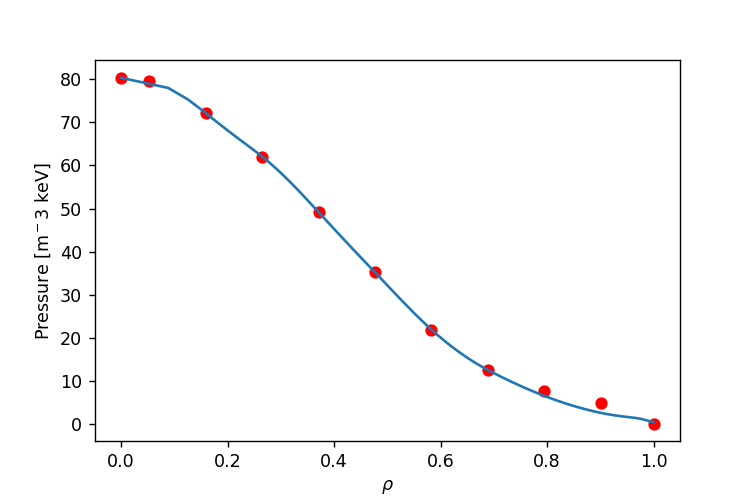

Text(0.5, 0, '$\\rho$')

In [34]:
%matplotlib notebook
plt.plot(np.sqrt(psi_norm), pressure_trin_units)
#plt.plot(psi_norm, pressure_trin_units)
plt.scatter(np.sqrt(psicore), pcore/(factor1), color='red')
plt.ylabel(r'Pressure [m$^-3$ keV]')
plt.xlabel(r'$\rho$')

<IPython.core.display.Javascript object>


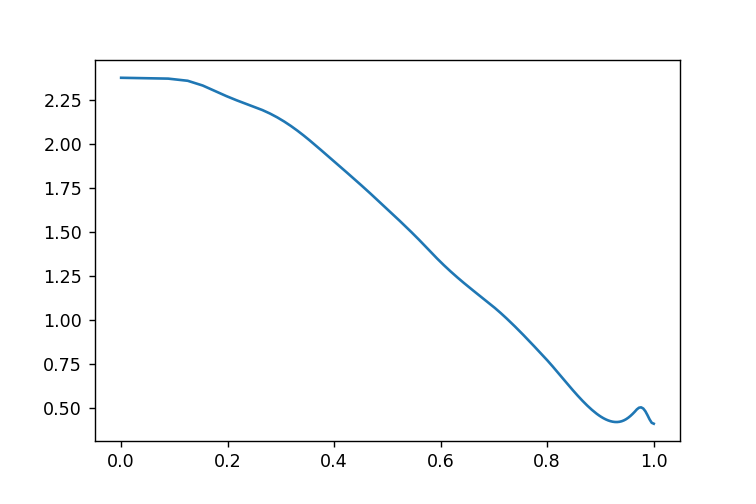

In [33]:
plt.plot(rho_array, pressure_trin_units/((Tnew_trinity + Tinew_trinity)))

Line Average Density wrong: 1.1485410777802556


<IPython.core.display.Javascript object>


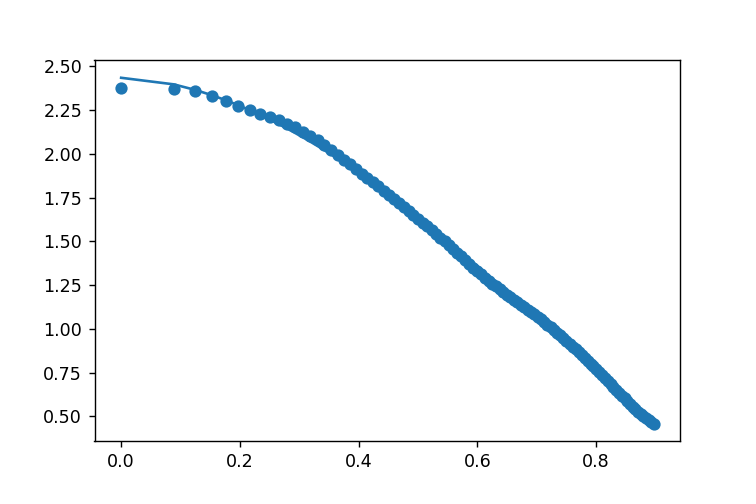

alpha1: 1.7918377502956215, alpha:  1.3289069536145224


In [35]:
# fit the curve to the data in the form of the density profile function 
from scipy.optimize import curve_fit
%matplotlib notebook
#Tnew_trinity, Tinew_trinity

idx_09 = np.argmin(np.abs(np.sqrt(psi_norm) - 0.9))
n_proff = pressure_trin_units / (Tnew_trinity + Tinew_trinity)
#n_lineavg = 1.30#np.average(n_proff)
print(f'Line Average Density wrong: {np.average(n_proff)}')

#n_edge = n_proff[idx_09]

def n_profile(rho, alpha1, alpha, n_lineavg, n_edge):
    n_prof = (1 - rho**alpha1)**alpha
    return (n_lineavg - n_edge) / np.average(n_prof) * n_prof + n_edge


popt, pcov = curve_fit(n_profile, np.sqrt(psi_norm)[:idx_09], n_proff[:idx_09])

rho_array = np.sqrt(psi_norm)
rho_array_09 = rho_array[:idx_09]

n_fit = n_profile(rho_array_09, popt[0], popt[1], popt[2], popt[3])
plt.plot(rho_array_09, n_fit)
plt.scatter(rho_array[:idx_09], n_proff[:idx_09])

alpha1 = popt[0]
alpha = popt[1]
#print(n_profile(np.linspace(0, 1, 10), popt[0], popt[1]))
# print(n_fit[0])
# print(rho_array_09[0])
# print(np.linspace(0, 1, 10))
print(f'alpha1: {alpha1}, alpha:  {alpha}')

In [69]:
#popt_save = popt

In [38]:

n_fit2 = n_profile(rho_array_09, popt_save[0], popt_save[1], popt_save[2], popt_save[3])
plt.plot(rho_array_09, n_fit)
plt.plot(rho_array_09, n_fit2)

NameError: name 'popt_save' is not defined

In [37]:
trinity_rho
Tedge = (T_e[-1] + T_i[-1]) / 2
T_core = (T_e[0] + T_i[0]) / 2
pedge = (T_e[-1] + T_i[-1]) / 2
p_core = pcore[0]/factor1
pedge = pcore[-1]/factor1

p_e = data['p_e'][-1]
pe_0 = 1.01*p_e[0]
ne_core = pe_0/T_e[0]
ne_edge = 0 #TODO: update this
T_core

16.915056271634622

In [45]:
n_0 = n_fit[0]
n_90 = n_fit[-1]
print(n_0)
print(n_90)

alphas_n0_n09 = np.array([alpha1, alpha, n_0, n_90])
export_dict = {'pressure_profile': (pressure2/factor1), 
               'pressure_rho': np.sqrt(psi_norm), 
               'alpha1_alpha_n0_n09':alphas_n0_n09,
               'J_profile': Jnew_trinity,
               'T_core_keV': T_core,
               'T_sep_keV': Tedge,
               'ne20_core': ne_core,
               'ne20_sep': ne_edge}
np.save('iteration1_dict.npy', export_dict, allow_pickle=True)
# export_dict = {'pressure_profile': (pressure2/factor1), 
#                'pressure_rho': trinity_rho, 
#                'alpha1_alpha_n0_n09':alphas_n0_n09,
#                'J_profile': Jnew_trinity,
#                'T_core_keV': T_core,
#                'T_sep_keV': Tedge,
#                'ne20_core': ne_core,
#                'ne20_sep': ne_edge}
# np.save('iteration1_dict.npy', export_dict, allow_pickle=True)

with open('nprofile.txt','w') as f:
    txt = f'alpha1: {alpha1}\nalpha: {alpha}\nn0: {n_0}\nn09: {n_90}'
    f.write(txt)

2.4342810909147685
0.4720180255471799


In [46]:
with open('iteration1_dict.npy', 'rb') as f:  #'transport_iter1b_new.npy' 'log_trinity_hires.npy'
    load = np.load(f, allow_pickle=True).tolist()
    
load.keys()

dict_keys(['pressure_profile', 'pressure_rho', 'alpha1_alpha_n0_n09', 'J_profile', 'T_core_keV', 'T_sep_keV', 'ne20_core', 'ne20_sep'])

In [47]:
print(load['pressure_profile'].shape[0])
print(load['J_profile'].shape[0])
print(load['alpha1_alpha_n0_n09'])
print(load['pressure_rho'].shape[0])
print(np.sqrt(psi_norm).shape[0])

129
129
[1.79183775 1.32890695 2.43428109 0.47201803]
129
129


<IPython.core.display.Javascript object>


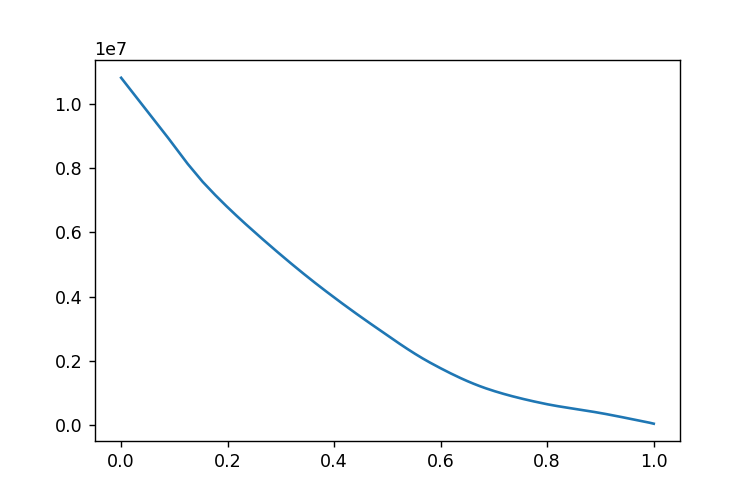

In [48]:
plt.plot(load['pressure_rho'], load['J_profile']) 

<IPython.core.display.Javascript object>


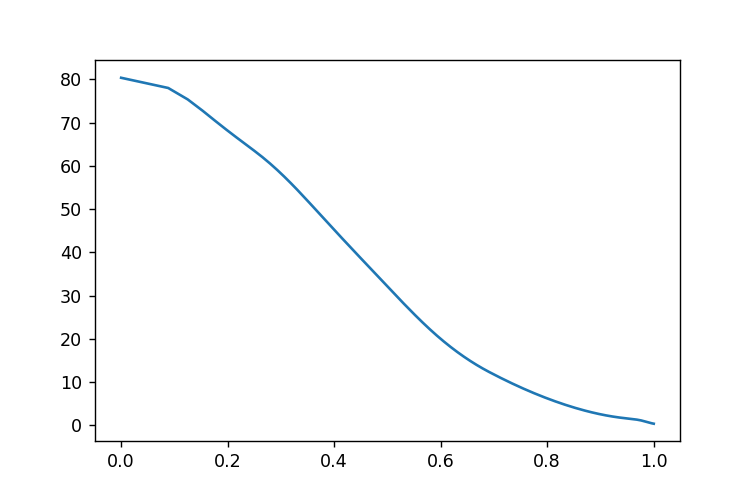

In [49]:
plt.plot(load['pressure_rho'], load['pressure_profile']) 

{'ax': {(1, 3, 1): <matplotlib.axes._subplots.AxesSubplot at 0x17973ee8f88>,
  (2, 3, 2): <matplotlib.axes._subplots.AxesSubplot at 0x17975b60fc8>,
  (2, 3, 3): <matplotlib.axes._subplots.AxesSubplot at 0x17975ca1b48>,
  (2, 3, 5): <matplotlib.axes._subplots.AxesSubplot at 0x17975d22108>,
  (2, 3, 6): <matplotlib.axes._subplots.AxesSubplot at 0x17975d36f08>}}

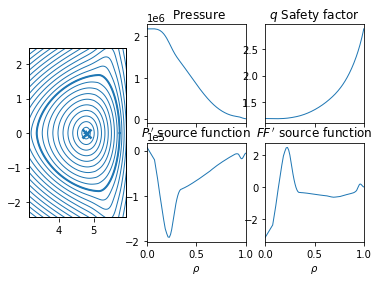

In [26]:
from matplotlib.pyplot import show
%matplotlib inline
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
from omfit_classes.omfit_gacode import OMFITgacode
from omas import *
geq = OMFITgeqdsk('gNTARC_iter1_small_pedestal_n_17')
geq['fluxSurfaces'].load()

# convert gEQDSK to OMAS data structure
ods = geq.to_omas()

# omas plots using functional approach
omas_plot.equilibrium_summary(ods, linewidth=1)

# omas plots using object-oriented approach
# ods.plot_equilibrium_summary(linewidth=1)

# =====================
# plotting profiles
# =====================
# # read input.profiles file in OMFIT
# ip = OMFITgacode('gNTARC_iter1_small_pedestal_n_17')

# # convert input.profiles to OMAS data structure
# ods = ip.to_omas()

# # omas plots using functional approach
# # omas_plot.core_profiles_summary(ods)

# # omas plots using object-oriented approach
# ods.plot_core_profiles_summary()

# show()